In [1]:
import tensorflow as tf
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-07-03 05:50:09.161661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751521809.323462      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751521809.381478      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths
input_dir = '/kaggle/input/brain-ct-sinograms-64-10000/Datasets/brain_CT_sinograms_64_augmented'
output_dir = '/kaggle/input/brain-ct-sinograms-64-10000/Datasets/brain_CT_64_augmented'

# Get sorted file names (to ensure matching)
input_files = sorted(os.listdir(input_dir))
output_files = sorted(os.listdir(output_dir))


In [3]:
# Initialize lists
x_data = []
y_data = []

# Load images
for in_file, out_file in zip(input_files, output_files):
    # Load grayscale image and resize to (256, 256)
    input_img = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(91,64))
    output_img = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(64, 64))
    
    # Convert to array and normalize to [0, 1]
    x = img_to_array(input_img) / 255.0
    y = img_to_array(output_img) / 255.0

    x_data.append(x)
    y_data.append(y)

# Convert to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("Input shape:", x_data.shape)   # (125, 256, 256, 1)
print("Output shape:", y_data.shape)  # (125, 256, 256, 1)

Input shape: (10000, 91, 64, 1)
Output shape: (10000, 64, 64, 1)


In [4]:
x_train = x_data[:9500]
x_test = x_data[9500:]
y_train = y_data[:9500]
y_test = y_data[9500:]

In [5]:
print(x_train.shape)
print(y_train.shape)

(9500, 91, 64, 1)
(9500, 64, 64, 1)


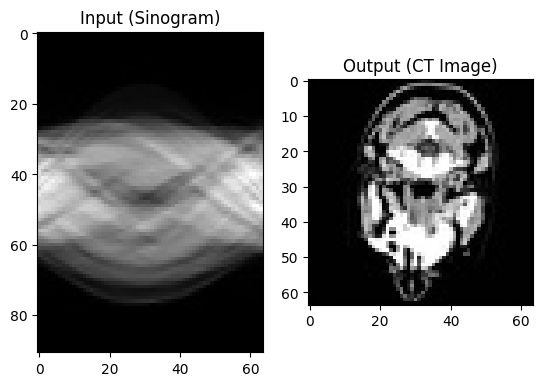

In [6]:
index = 4

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(x_data[index].squeeze(), cmap='gray')
plt.title('Input (Sinogram)')

plt.subplot(1, 2, 2)
plt.imshow(y_data[index].squeeze(), cmap='gray')
plt.title('Output (CT Image)')
plt.show()

# Model

In [7]:
import tensorflow as tf
from tensorflow.keras.metrics import Mean

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [8]:
from tensorflow.keras import models, layers

def build_automap(input_shape=(91, 64, 1), dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Flatten the input
    x = layers.Flatten()(inputs)

    # Fully connected layers
    x = layers.Dense(91 * 64, activation='relu')(x)
    x = layers.Dense(64 * 64, activation='sigmoid')(x)  # sigmoid to keep output in [0,1]

    # Reshape to image
    outputs = layers.Reshape((64, 64, 1))(x)

    return models.Model(inputs, outputs)



from tensorflow.keras import layers, models

def build_automap_v4(input_shape=(91, 64, 1)):
    inputs = layers.Input(shape=input_shape)             # Sinogram input (90x128)
    x = layers.Flatten()(inputs)                         # Shape: (11520,)
    
    # Fully connected layer to 64x64
    x = layers.Dense(64 * 64, activation='tanh')(x)         # FC1
    x = layers.Reshape((64, 64, 1))(x)                   # Reshape for ConvNet
    
    # 1st Conv layer
    x = layers.Conv2D(128, (3, 3), padding='same', activation='tanh')(x)
    # 2nd Conv layer
    x = layers.Conv2D(128, (3, 3), padding='same', activation='tanh')(x)
    # 3rd Conv layer
    x = layers.Conv2D(128, (3, 3), padding='same', activation='tanh')(x)
    # 4th Conv layer
    x = layers.Conv2D(128, (3, 3), padding='same', activation='tanh')(x)
    # 5th Conv layer (final)
    x = layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(x)
    
    return models.Model(inputs, x)



In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=40, restore_best_weights=True)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
model = build_automap_v4()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError(), metrics=[psnr_metric, ssim_metric])

I0000 00:00:1751521915.192158      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751521915.192871      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 91, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5824)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      23,859,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,304,385 (92.71 MB)

 Trainable params: 24,304,385 (92.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import matplotlib.pyplot as plt


history = model.fit(
    x_train, y_train,
    epochs=300,
    batch_size=8,
    validation_data=(x_test, y_test),
    callbacks = [early_stop]
)



Epoch 1/300


I0000 00:00:1751521926.192606      99 service.cc:148] XLA service 0x7a82ec0036b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751521926.193062      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751521926.193077      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1751521926.397723      99 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1751521926.398476      99 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1751521926.399954      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1751521926.400656      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1751521926.401516      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1751521926.402086      99 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Asse

   7/1188 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.1328 - psnr_metric: 8.9132 - ssim_metric: 0.0614 

I0000 00:00:1751521929.645871      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0368 - psnr_metric: 14.7721 - ssim_metric: 0.2172

W0000 00:00:1751521953.809422      96 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1751521953.809694      96 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1751521953.810211      96 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1751521953.810464      96 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1751521953.810740      96 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1751521953.810917      96 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0368 - psnr_metric: 14.7738 - ssim_metric: 0.2173

W0000 00:00:1751521956.357379      97 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1751521956.358340      97 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1751521956.360217      97 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1751521956.360945      97 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1751521956.361850      97 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1751521956.362421      97 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1751521957.163132      98 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1751521957.163354      98 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 0.0368 - psnr_metric: 14.7746 - ssim_metric: 0.2174 - val_loss: 0.0223 - val_psnr_metric: 16.6976 - val_ssim_metric: 0.3505
Epoch 2/300
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0210 - psnr_metric: 17.0223 - ssim_metric: 0.3686 - val_loss: 0.0177 - val_psnr_metric: 17.8487 - val_ssim_metric: 0.4254
Epoch 3/300
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.0181 - psnr_metric: 17.6668 - ssim_metric: 0.4224 - val_loss: 0.0165 - val_psnr_metric: 18.1715 - val_ssim_metric: 0.4654
Epoch 4/300
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0164 - psnr_metric: 18.1193 - ssim_metric: 0.4698 - val_loss: 0.0158 - val_psnr_metric: 18.3157 - val_ssim_metric: 0.4815
Epoch 5/300
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.0153 - psnr_metric: 18.4748 - ssim_metric: 0.5169 - val_loss: 0.0150 - val_psnr_metric: 18.6545 - val_ssim_metric: 0.5284
Epoch 6/300
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.

In [15]:
history.history.keys()


dict_keys(['loss', 'psnr_metric', 'ssim_metric', 'val_loss', 'val_psnr_metric', 'val_ssim_metric'])

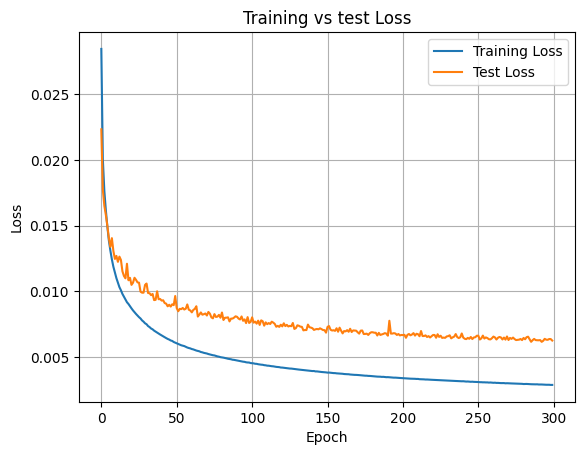

In [19]:
# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test Loss')
plt.legend()
plt.grid(True)
plt.show()



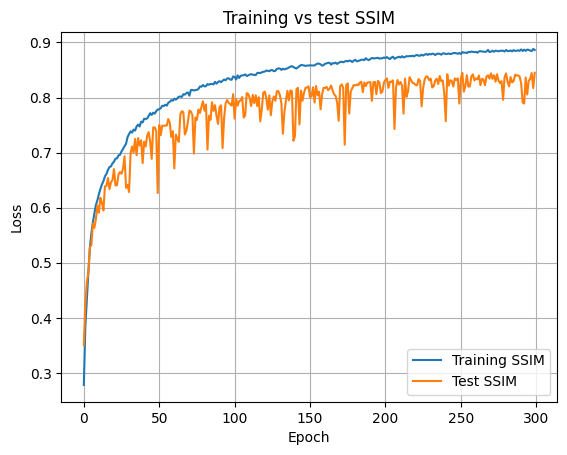

In [20]:
# Plot Training vs Validation Loss
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test SSIM')
plt.legend()
plt.grid(True)
plt.show()


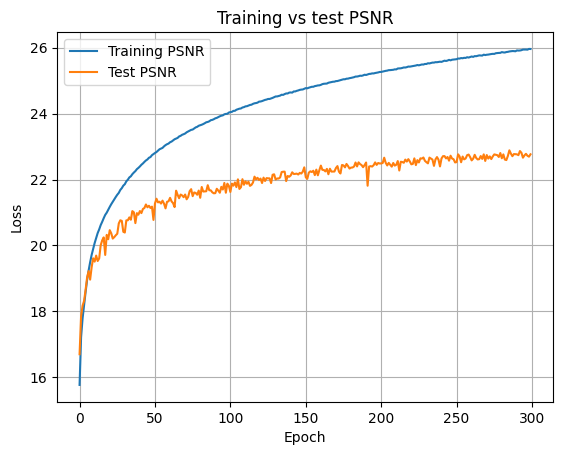

In [21]:
# Plot Training vs Validation Loss
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Test PSNR')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test PSNR')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation by Plotting Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


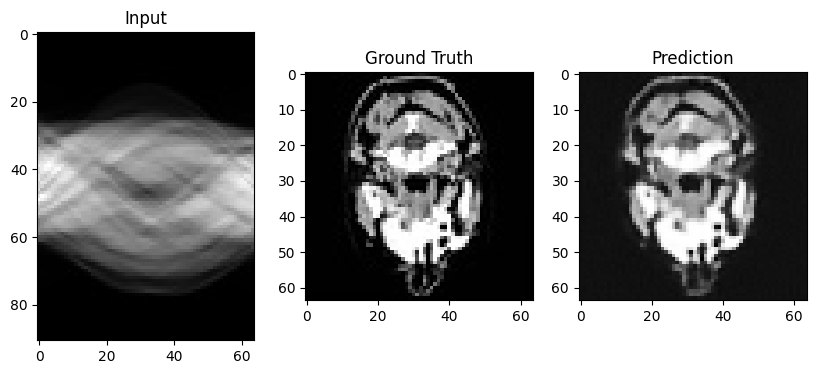

In [22]:
import matplotlib.pyplot as plt

i = 50# index of sample
pred = model.predict(x_train[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


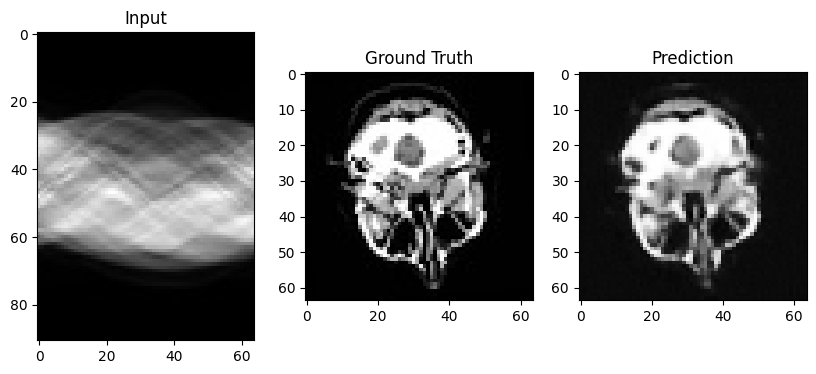

In [25]:
import matplotlib.pyplot as plt

i = 200# index of sample
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


## Evaluate using PSNR and SSIM

In [ ]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_test[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_test[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


In [ ]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_train[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_train[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


In [ ]:
model.save('automap_v4_dense_300.h5')